In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from skimage.feature import hog
import json
from googleplaces import GooglePlaces, types, lang
import re
import requests
import os
import zipfile
import pickle

In [2]:
veh_img_arr=glob.glob('./vehicles/*/*.png')

veh_img_orig=[]
for imgPath in veh_img_arr:
    img=cv2.imread(imgPath)
    rgbImg=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    veh_img_orig.append(rgbImg)

print('Reading of Vehicle Images Done')
print('No. of Vehicle Images loaded='+str(len(veh_img_arr)))

non_veh_orig=[]
non_veh_arr=glob.glob('./non-vehicles/*/*.png')
for imgPath in non_veh_arr:
    img=cv2.imread(imgPath)
    rgbImg=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    non_veh_orig.append(rgbImg)



print('Reading of Non-Vehicle Images Done')
print('No. of Non-Vehicle Images loaded='+str(len(non_veh_arr)))

Reading of Vehicle Images Done
No. of Vehicle Images loaded=8792
Reading of Non-Vehicle Images Done
No. of Non-Vehicle Images loaded=8968


Shape of Vehicle image=(64, 64, 3)
Shape of Non-Vehicle image=(64, 64, 3)


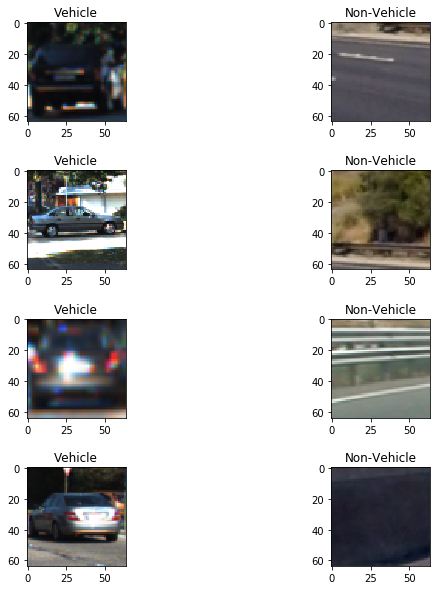

In [5]:
f,axes = plt.subplots(4,2,figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

for index in range(4):
    veh=rn.randint(0,len(veh_img_orig)-1)
    non_veh=rn.randint(0,len(non_veh_arr)-1)
    axes[index,0].imshow(veh_img_orig[veh])
    axes[index,0].set_title('Vehicle')
    axes[index,1].imshow(non_veh_orig[non_veh])
    axes[index,1].set_title('Non-Vehicle')

print('Shape of Vehicle image='+str(veh_img_orig[veh].shape))
print('Shape of Non-Vehicle image='+str(non_veh_orig[non_veh].shape))

In [6]:
def ExtractColorHistogram(image,nbins=32,bins_range=(0,255),resize=None):
    if(resize!=None):
        image=cv2.resize(image,resize)
    r_channel=np.histogram(image[:,:,0],bins=nbins,range=bins_range)
    g_channel=np.histogram(image[:,:,1],bins=nbins,range=bins_range)
    b_channel=np.histogram(image[:,:,2],bins=nbins,range=bins_range)
    return r_channel,g_channel,b_channel

def FindBinCenter(histogram_channel):
    bin_edges=histogram_channel[1]
    bin_centers=(bin_edges[1:]+bin_edges[0:len(bin_edges)-1])/2
    return bin_centers

def ExtractColorFeatures(r_channel,g_channel,b_channel):
    return np.concatenate((r_channel[0],g_channel[0],b_channel[0]))                              

No. of Features=384


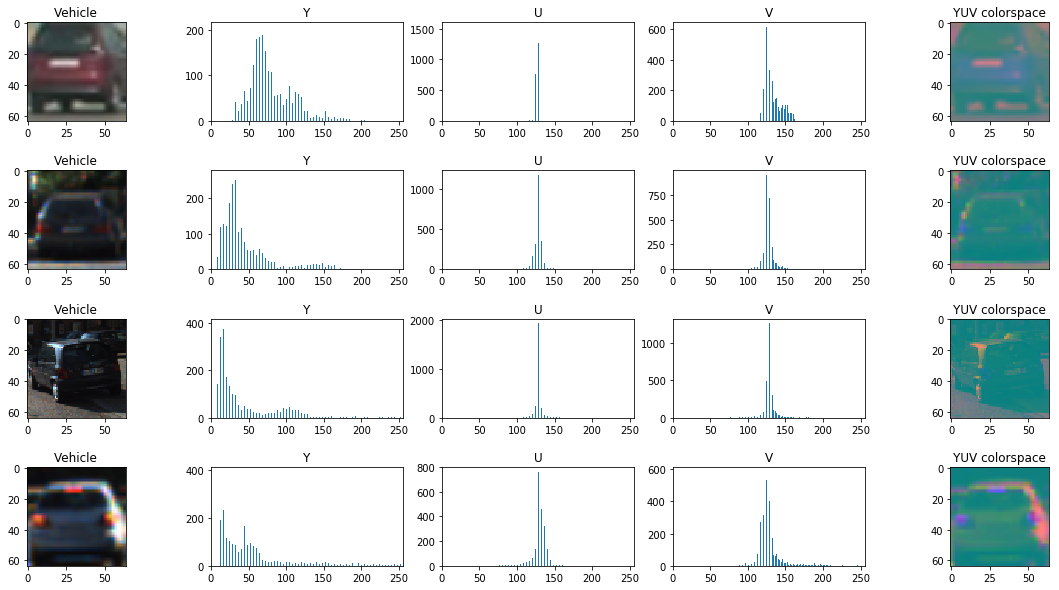

In [7]:
f,axes=plt.subplots(4,5,figsize=(20,10))
f.subplots_adjust(hspace=0.5)

for i in range(4):
    veh=rn.randint(0,len(veh_img_orig)-1)
    coloredImg=cv2.cvtColor(veh_img_orig[veh],cv2.COLOR_RGB2YUV)
    r,g,b = ExtractColorHistogram(coloredImg,128)
    center=FindBinCenter(r)
    
    axes[i,0].imshow(veh_img_orig[veh])
    axes[i,0].set_title('Vehicle')
    axes[i,1].set_xlim(0,256)
    axes[i,1].bar(center,r[0])
    axes[i,1].set_title('Y')
    axes[i,2].set_xlim(0,256)
    axes[i,2].bar(center,g[0])
    axes[i,2].set_title('U')
    axes[i,3].set_xlim(0,256)
    axes[i,3].bar(center,b[0])
    axes[i,3].set_title('V')
    axes[i,4].imshow(coloredImg)
    axes[i,4].set_title("YUV colorspace")
    
features=ExtractColorFeatures(r,g,b)
print('No. of Features='+str(len(features)))

No. of Features=384


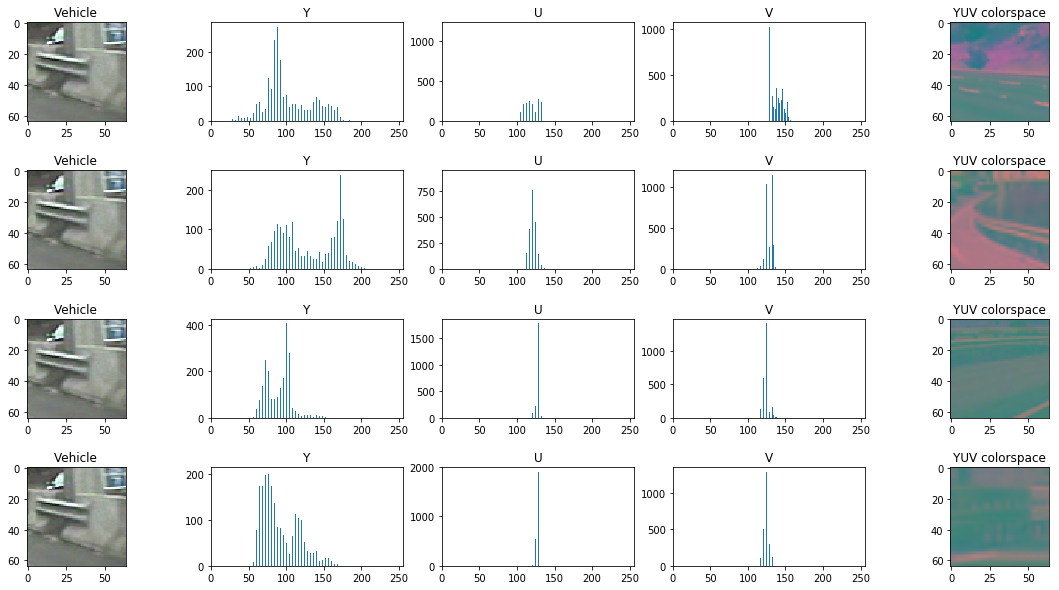

In [8]:
f,axes=plt.subplots(4,5,figsize=(20,10))
f.subplots_adjust(hspace=0.5)

for i in range(4):
    non_veh=rn.randint(0,len(non_veh_orig)-1)
    coloredImg=cv2.cvtColor(non_veh_orig[non_veh],cv2.COLOR_RGB2YUV)
    r,g,b = ExtractColorHistogram(coloredImg,128)
    center=FindBinCenter(r)
    
    axes[i,0].imshow(non_veh_orig[veh])
    axes[i,0].set_title('Vehicle')
    axes[i,1].set_xlim(0,256)
    axes[i,1].bar(center,r[0])
    axes[i,1].set_title('Y')
    axes[i,2].set_xlim(0,256)
    axes[i,2].bar(center,g[0])
    axes[i,2].set_title('U')
    axes[i,3].set_xlim(0,256)
    axes[i,3].bar(center,b[0])
    axes[i,3].set_title('V')
    axes[i,4].imshow(coloredImg)
    axes[i,4].set_title("YUV colorspace")
    
features=ExtractColorFeatures(r,g,b)
print('No. of Features='+str(len(features)))

In [10]:
def SpatialBinningFeatures(img,size):
    img=cv2.resize(img,size)
    return img.ravel()

In [11]:
featureList=SpatialBinningFeatures(veh_img_orig[1],(16,16))
print('No. of Features before Spatial Binning='+str(len(veh_img_orig[1].ravel())))
print('No. of Features after Spatial Binning='+str(len(featureList)))

No. of Features before Spatial Binning=12288
No. of Features after Spatial Binning=768


In [3]:
def GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True):
    if(visualise==True):
        hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=True, feature_vector=feature_vector_flag)
        return hog_features, hog_image
    else:
        hog_features = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=False, feature_vector=feature_vector_flag)
        return hog_features

C:\Users\dell\Anaconda2_32bit_2.7\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\dell\Anaconda2_32bit_2.7\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


('Feature Vector Length returned =', 324)
('No of features that can be extracted =', 4096)


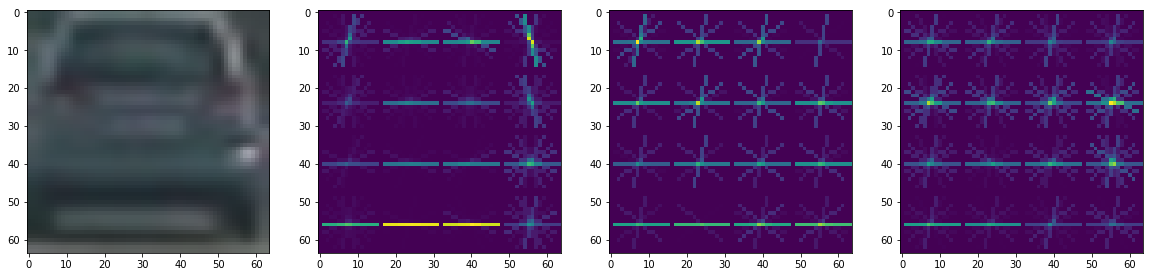

In [13]:
img=veh_img_orig[10]
yuv_img=cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

img_channel_0=yuv_img[:,:,0]
img_channel_1=yuv_img[:,:,1]
img_channel_2=yuv_img[:,:,2]

feature_0, hog_img_0=GetFeaturesFromHog(img_channel_0,9,2,16,visualise=True,feature_vector_flag=True)
feature_1, hog_img_1=GetFeaturesFromHog(img_channel_1,9,2,16,visualise=True,feature_vector_flag=True)
feature_2, hog_img_2=GetFeaturesFromHog(img_channel_2,9,2,16,visualise=True,feature_vector_flag=True)

f, axes=plt.subplots(1,4,figsize=(20,10))
axes[0].imshow(img)
axes[1].imshow(hog_img_0)
axes[2].imshow(hog_img_1)
axes[3].imshow(hog_img_2)

print("Feature Vector Length returned =",len(feature_0))
print('No of features that can be extracted =',len(hog_img_0.ravel()))

In [14]:
def ConvertImgColorSpace(img, colorspace):
    return cv2.cvtColor(img, colorspace)

In [4]:
def ExtractFeatures(images,orientation,cellsPerBlock,pixelsPerCell,convertColorspace=False):
    featureList=[]
    imageList=[]
    for image in images:
        if(convertColorspace==True):
            image=cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        local_features0=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell,False,True)
        local_features1=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell,False,True)
        local_features2=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell,False,True)
        x=np.hstack((local_features0,local_features1,local_features2))
        featureList.append(x)
    return featureList

In [5]:
%%time

orientations=9
cellsPerBlock=2
pixelsPerCell=16
convertColorspace=True
vehicleFeatures=ExtractFeatures(veh_img_orig,orientations,cellsPerBlock,pixelsPerCell,convertColorspace)
nonVehicleFeatures=ExtractFeatures(non_veh_orig,orientations,cellsPerBlock,pixelsPerCell,convertColorspace)

C:\Users\dell\Anaconda2_32bit_2.7\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\dell\Anaconda2_32bit_2.7\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Wall time: 52 s


In [17]:
featuresList=np.vstack([vehicleFeatures,nonVehicleFeatures])
print("Shape of features list is ", featuresList.shape)
labelList= np.concatenate([np.ones(len(vehicleFeatures)), np.zeros(len(nonVehicleFeatures))])
print("Shape of label list is ", labelList.shape)

('Shape of features list is ', (17760, 972))
('Shape of label list is ', (17760,))


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(featuresList, labelList, test_size=0.2, shuffle=True)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

In [20]:
%%time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
classifier2=AdaBoostClassifier(base_estimator=RandomForestClassifier(), n_estimators = 50, learning_rate = 1)
classifier2.fit(X_train, Y_train)
print("Accuracy of Adaboost is ", classifier2.score(X_test,Y_test))

C:\Users\dell\Anaconda2_32bit_2.7\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


('Accuracy of Adaboost is ', 0.9935247747747747)
Wall time: 4min 45s


In [21]:
import os
import math

def extractFrames(pathIn, pathOut):
    os.mkdir(pathOut)
 
    cap = cv2.VideoCapture(pathIn)
    frameRate = cap.get(5)
    count = 0
 
    while (cap.isOpened()):
        frameId = cap.get(1)
        
        # Capture frame-by-frame
        ret, frame = cap.read()
 
        if ret != True:
            break
        if (frameId % (5*math.floor(frameRate)) == 0):
            print('Read %d frame: ' % count, ret)
            cv2.imwrite(os.path.join(pathOut, "frame{:d}.jpg".format(count)), frame)  # save frame as JPEG file
            count += 1
                
 
    cap.release()
    cv2.destroyAllWindows()
    

extractFrames('project_video.mp4', 'data')

('Read 0 frame: ', True)
('Read 1 frame: ', True)
('Read 2 frame: ', True)
('Read 3 frame: ', True)
('Read 4 frame: ', True)
('Read 5 frame: ', True)
('Read 6 frame: ', True)
('Read 7 frame: ', True)
('Read 8 frame: ', True)
('Read 9 frame: ', True)
('Read 10 frame: ', True)


In [7]:
import matplotlib.image as mpimg

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    
    for bbox in bboxes:
        r=rn.randint(0,255)
        g=rn.randint(0,255)
        b=rn.randint(0,255)
        color=(r,g,b)
        cv2.rectangle(imcopy,bbox[0],bbox[1],color,thick)
    return imcopy

In [8]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.9, 0.9)):
    if x_start_stop[0] == None:
        x_start_stop[0]=0
    if x_start_stop[1] == None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] ==  None:
        y_start_stop[0]= 0
    if y_start_stop[1] ==  None:
        y_start_stop[1]=img.shape[0]
    
    window_list = []
    image_width_x= x_start_stop[1] - x_start_stop[0]
    image_width_y= y_start_stop[1] - y_start_stop[0]
    
    windows_x = np.int( 1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
    windows_y = np.int( 1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))

    modified_window_size= xy_window
    for i in range(0,windows_y):
        y_start = y_start_stop[0] + np.int( i * modified_window_size[1] * xy_overlap[1])
        for j in range(0,windows_x):
            x_start = x_start_stop[0] + np.int( j * modified_window_size[0] * xy_overlap[0])
            
            x1 = np.int( x_start +  modified_window_size[0])
            y1= np.int( y_start + modified_window_size[1])
            window_list.append(((x_start,y_start),(x1,y1)))
    return window_list

In [16]:
def drawCars(image, windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        start=window[0]
        end=window[1]
        
        print(start)
        print(end)
        
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        if(clippedImage.shape[1]==clippedImage.shape[0] and clippedImage.shape[1]!=0):
            clippedImage=cv2.resize(clippedImage, (64,64))
            f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
            predictedOutput=classifier2.predict([f1[0]])
            if(predictedOutput==1):
                refinedWindows.append(window)    
    return refinedWindows        

('Total No of windows are ', 140)
(0, 550)
(96, 646)


C:\Users\dell\Anaconda2_32bit_2.7\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\dell\Anaconda2_32bit_2.7\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


(43, 550)
(139, 646)
(86, 550)
(182, 646)
(129, 550)
(225, 646)
(172, 550)
(268, 646)
(216, 550)
(312, 646)
(259, 550)
(355, 646)
(302, 550)
(398, 646)
(345, 550)
(441, 646)
(388, 550)
(484, 646)
(432, 550)
(528, 646)
(475, 550)
(571, 646)
(518, 550)
(614, 646)
(561, 550)
(657, 646)
(604, 550)
(700, 646)
(648, 550)
(744, 646)
(691, 550)
(787, 646)
(734, 550)
(830, 646)
(777, 550)
(873, 646)
(820, 550)
(916, 646)
(864, 550)
(960, 646)
(907, 550)
(1003, 646)
(950, 550)
(1046, 646)
(993, 550)
(1089, 646)
(1036, 550)
(1132, 646)
(1080, 550)
(1176, 646)
(1123, 550)
(1219, 646)
(1166, 550)
(1262, 646)
(0, 574)
(96, 670)
(43, 574)
(139, 670)
(86, 574)
(182, 670)
(129, 574)
(225, 670)
(172, 574)
(268, 670)
(216, 574)
(312, 670)
(259, 574)
(355, 670)
(302, 574)
(398, 670)
(345, 574)
(441, 670)
(388, 574)
(484, 670)
(432, 574)
(528, 670)
(475, 574)
(571, 670)
(518, 574)
(614, 670)
(561, 574)
(657, 670)
(604, 574)
(700, 670)
(648, 574)
(744, 670)
(691, 574)
(787, 670)
(734, 574)
(830, 670)
(777, 

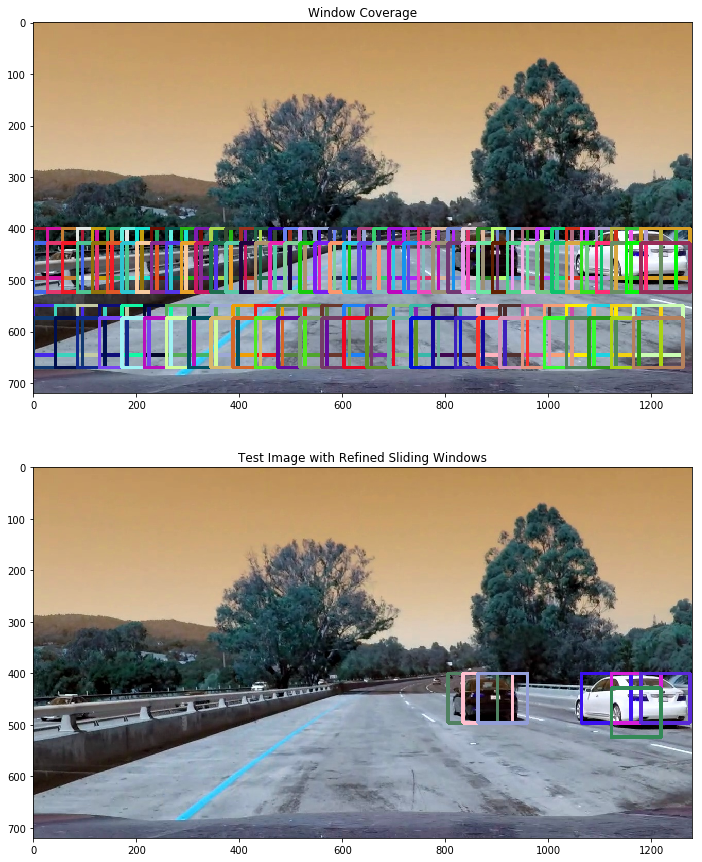

In [17]:
image = cv2.imread('frame8.JPG')

windows1 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[550,690], 
                    xy_window=(96,96), xy_overlap=(0.45, 0.25))
windows4 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[650,700], 
                    xy_window=(80,80), xy_overlap=(0.6, 0.6))
windows2 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,540], 
                    xy_window=(96,96), xy_overlap=(0.3, 0.3))
windows3 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[700,800], 
                    xy_window=(128,128), xy_overlap=(0.6, 0.6))

windows = windows1 + windows2 +  windows3 + windows4
print("Total No of windows are ",len(windows))
refinedWindows=drawCars(image,windows, True)

f,axes= plt.subplots(2,1, figsize=(30,15))

window_img = draw_boxes(image, windows) 

axes[0].imshow(window_img)
axes[0].set_title("Window Coverage")

window_img = draw_boxes(image, refinedWindows) 

axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)

In [26]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap 

In [27]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [28]:
from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

(' Number of Cars found - ', 2)


Text(0.5,1,'Final Image after applying Heat Map')

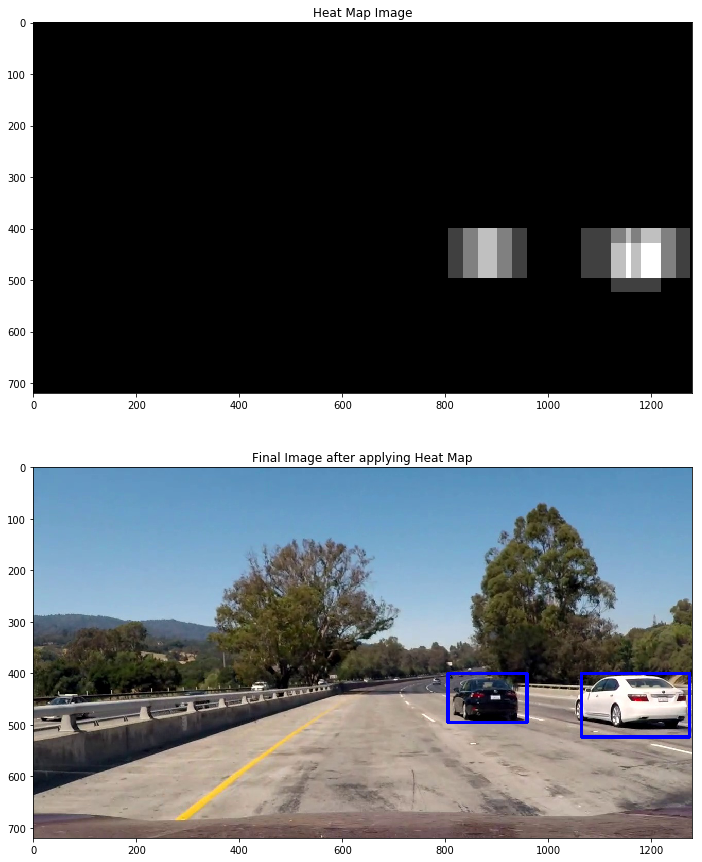

In [29]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,refinedWindows)
    
heat = apply_threshold(heat,0)

heatmap = np.clip(heat, 0, 255)

heat_image=heatmap

labels = label(heatmap)
print(" Number of Cars found - ",labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)

f,axes= plt.subplots(2,1, figsize=(30,15))
axes[0].imshow(heat_image,cmap='gray')
axes[0].set_title("Heat Map Image")
axes[1].imshow(draw_img)
axes[1].set_title("Final Image after applying Heat Map")

In [30]:
class KeepTrack():
    def __init__(self):
        self.refinedWindows = [] 
        
    def AddWindows(self, refinedWindow):
        self.refinedWindows.append(refinedWindow)
        frameHistory=15
        if len(self.refinedWindows) > frameHistory:
            self.refinedWindows = self.refinedWindows[len(self.refinedWindows)-frameHistory:]

In [31]:
orientation=9 # No of orientations of HOG
cellsPerBlock=2 # No of cells per block
pixelsPerCell=16 # No of pixels per cell
xy_window=(96, 96) # window Size
xy_overlap=(0.45, 0.25) # Window Overlap. Please note this is different as provided by Udacity. Overlap of 0.15 means my windows are 85% overlapping with each other
x_start_stop=[0, image.shape[1]] # X Coordinates to start and stop search
y_start_stop=[550, 690] # Y Coordinates to start and stop search

# Window 1- Size - 64x64 , Overlap-85%
windows_normal = slide_window(image, x_start_stop, [550,690], 
                    xy_window, xy_overlap)

# Window 2- Size - 80x80 , Overlap-80%
xy_window_1_25= (80,80)
xy_window_1_25_overlap=(0.6, 0.6)    
windows_1_25 = slide_window(image, x_start_stop, [650,700], 
                    xy_window_1_25, xy_window_1_25_overlap)

# Window 3- Size - 96x96 , Overlap-70%
xy_window_1_5= (96,96)
xy_window_1_5_overlap=(0.3, 0.3)    
windows_1_5 = slide_window(image, x_start_stop, [400,540], 
                    xy_window_1_5, xy_window_1_5_overlap)

# Window 4- Size - 128x128 , Overlap-50%
xy_window_twice_overlap=(0.6, 0.6)    
xy_window_twice = (128,128)
windows_twice = slide_window(image, x_start_stop, [700,800], 
                    xy_window_twice, xy_window_twice_overlap)

# Total Windows - 470
windows= windows_normal +  windows_1_5  + windows_twice +windows_1_25
print("No of Windows are ",len(windows))

('No of Windows are ', 140)


In [32]:
def Pipeline(image):
#     features,hog_image=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=False)
#     features1,hog_image1=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=False)
#     features2,hog_image2=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=False)
#     refinedWindows=DrawCarsOptimised(hog_image,hog_image1,hog_image2,windows, True)
    
#     image=find_cars(image, 400, 528, 1,  orientation, pixelsPerCell, cellsPerBlock)
#     image=find_cars(image, 400, 560, 1.25,  orientation, pixelsPerCell, cellsPerBlock)
#     image=find_cars(image, 400, 588, 1.5,  orientation, pixelsPerCell, cellsPerBlock)
#     image=find_cars(image, 400, 660, 2,  orientation, pixelsPerCell, cellsPerBlock)
    rand= rn.randint(0,1)
    if(rand<0.4):
        refinedWindows=keepTrack.refinedWindows[:-1]
    else:
        refinedWindows=drawCars(image,windows, True)
        if len(refinedWindows) > 0:
            keepTrack.AddWindows(refinedWindows)
    
    #refinedWindows=DrawCars(image,windows, True)
#     if len(refinedWindows) > 0:
#         keepTrack.AddWindows(refinedWindows)
            
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for refinedWindow in keepTrack.refinedWindows:
        heat = add_heat(heat, refinedWindow)
    
    
    
    heatmap = apply_threshold(heat, 25 + len(keepTrack.refinedWindows)//2)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [33]:
def PipelineImage(image):

    refinedWindows=drawCars(image,windows, True)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,refinedWindows)
   
    heatmap = np.clip(heat, 0, 255)
    heatmap = apply_threshold(heat, 0)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img,heatmap,labels

In [34]:
%%time
import os
test_images= glob.glob("./data/*.jpg")
i=1
os.mkdir('Final')
for index,image in enumerate(test_images):
    image = cv2.imread(image)
    finalPic,heatmap, labels = PipelineImage(image)
    cv2.imwrite('./Final/%d.jpg'%i,finalPic)
    i=i+1
    print(labels[1])

0
0
2
2
1
1
1
1
1
2
1
Wall time: 1min 40s


In [2]:
import pickle

In [3]:
filename='final_model.sav'
pickle.dump(classifier2, open(filename,'wb'))

NameError: name 'classifier2' is not defined

In [5]:
classifier2 = pickle.load(open(filename, 'rb'))

In [38]:
import cPickle
with open('final_model.pkl', 'wb') as fid:
    cPickle.dump(classifier2, fid)

In [32]:
with open('final_model.pkl', 'rb') as fid:
    classifier = cPickle.load(fid)

In [39]:
from sklearn.externals import joblib
joblib.dump(classifier2, 'classifier.save')

['classifier.save']

In [6]:
classifier2

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          learning_rate=1, n_estimators=50, random_state=None)